In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

# LSTM Encoder Decoder


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM_Encoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers = 1):
        """
        LSTM Encoder Network
        Args:
            input_size (int): The number of input features.
            hidden_size (int): The number of features in the hidden state.
            num_layers (int, optional): Number of recurrent layers. Default is 1.

        Attributes:
            lstm (nn.LSTM): LSTM layer.
        """
        
        super(LSTM_Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        """
        Forward pass through the LSTM encoder.
        Args:
            x_input (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).
        
        Returns:
            tuple: (lstm_out, hidden) where lstm_out is the output features from the LSTM (batch_size, sequence_length, hidden_size)
                   and hidden is the hidden states (h_n, c_n) from the LSTM.
        """

        
        lstm_out, hidden = self.lstm(x_input)
        
        return lstm_out, hidden     
    
    def init_hidden(self, batch_size):
        """
        Initializes the hidden states.
        Args:
            batch_size (int): The batch size.
        
        Returns:
            tuple: Initial hidden states (h_0, c_0), each of shape (num_layers, batch_size, hidden_size).
        """
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

class LSTM_Decoder(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size, num_layers = 1):
        """
        LSTM Decoder Network
        Args:
            input_size (int): The number of input features.
            output_size (int): The number of output features.
            hidden_size (int): The number of features in the hidden state.
            num_layers (int, optional): Number of recurrent layers. Default is 1.

        Attributes:
            lstm (nn.LSTM): LSTM layer.
            linear (nn.Linear): Fully connected layer to convert hidden state to output.
        """

        super(LSTM_Decoder, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers


        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)           

    def forward(self, x_input, encoder_hidden_states):
        """
        Forward pass through the LSTM decoder.
        Args:
            x_input (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size).
            encoder_hidden_states (tuple): Hidden states from the encoder (h_n, c_n), each of shape (num_layers, batch_size, hidden_size).
        
        Returns:
            tuple: (output, hidden) where output is the output features from the decoder (batch_size, sequence_length, output_size)
                   and hidden is the hidden states (h_n, c_n) from the LSTM.
        """
        lstm_out, hidden = self.lstm(x_input, encoder_hidden_states)
        output = self.linear(lstm_out)     
    
        return output, hidden




# Gating Network Architecture


This network outputs the weights for the expert Motion Generators. The weights of the Motion Generators are blended using the gating network weights. Thus resulting into a Weight Blended Mixture of Expert model when combined together.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GatingNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,
                 in_frames_len, out_frames_len, 
                 num_experts, gating_hidden_size=128):
        super(GatingNetwork, self).__init__()
        self.W0 = nn.Linear(input_size, gating_hidden_size)
        self.W1 = nn.Linear(gating_hidden_size, gating_hidden_size)
        self.W2 = nn.Linear(gating_hidden_size, num_experts)

        self.encoder = LSTM_Encoder(input_size, hidden_size, num_layers)
        self.decoder = LSTM_Decoder(hidden_size, input_size, hidden_size, num_layers)
        self.in_frames_len = in_frames_len
        self.out_frames_len = out_frames_len

    def forward(self, x):
        # Gating weights
        last_input_frame = x[:, -1]
        omega = F.elu(self.W0(last_input_frame))
        omega = F.elu(self.W1(omega))
        omega = F.softmax(self.W2(omega), dim=-1)

        # Future Gating Features prediction
        encoder_out, hidden = self.encoder(x)
        
        decoder_in = encoder_out[:, :self.out_frames_len, :]
        
        decoder_out, _ = self.decoder(decoder_in, hidden)

        # # Trimming the decoded output to match the out_frames_len and matching features to input size
        future_phase_manifold = decoder_out[:, :self.out_frames_len]


        return omega, future_phase_manifold


Test network

In [4]:
input_size = 20
hidden_size = 30
num_layers = 2
in_frames_len = 7
out_frames_len = 5
num_experts = 4
gating_hidden_size=128

model = GatingNetwork(input_size, hidden_size, num_layers,
                 in_frames_len, out_frames_len, 
                 num_experts, gating_hidden_size)

ooj = torch.rand(64, in_frames_len, input_size)
print(ooj.shape)
a, b = model(ooj)

print(b.shape)
print(a.shape)


param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))



torch.Size([64, 7, 20])
torch.Size([64, 5, 20])
torch.Size([64, 4])
model size: 0.187MB


# Motion Expert

In [5]:
class MotionExpert(nn.Module):
    def __init__(self, in_frames_len, out_frames_len, num_joints):
        
        super(MotionExpert, self).__init__()
        
        self.in_frames_len = in_frames_len
        self.out_frames_len = out_frames_len
        self.num_joints = num_joints

        # For velocity
        self.v_actfn = nn.Tanh()
        self.v_ebn2d = nn.BatchNorm2d(num_joints)
        self.v_conv2d = nn.Conv2d(num_joints, num_joints, (in_frames_len, 3), (1, 1), ((in_frames_len-1)//2, 0))
        self.v_encoder = LSTM_Encoder(num_joints, num_joints*3, 2)
        self.v_decoder = LSTM_Decoder(num_joints*3, num_joints, num_joints*3, 2)
        self.v_convt2d = nn.ConvTranspose2d(num_joints, num_joints, (out_frames_len, 3), (1, 1), ((out_frames_len-1)//2, 0))

        # For Dual Quaternions
        self.dq_actfn = nn.Tanh()
        self.dq_ebn2d = nn.BatchNorm2d(num_joints)
        self.dq_conv2d = nn.Conv2d(num_joints, num_joints, (in_frames_len, 8), (1, 1), ((in_frames_len-1)//2, 0))
        self.dq_encoder = LSTM_Encoder(num_joints, num_joints*4, 3)
        self.dq_decoder = LSTM_Decoder(num_joints*4, num_joints, num_joints*4, 3)
        self.dq_convt2d = nn.ConvTranspose2d(num_joints, num_joints, (out_frames_len, 8), (1, 1), ((out_frames_len-1)//2, 0))

    def normalize_dq(self, dq):
        """
        This function enforces the unitary conditions for valid dual quaternions:
        1. The real part should have a norm of 1.
        2. The real and the dual parts should be orthogonal.

        Parameters:
            dq (torch.Tensor): A tensor containing dual quaternions of shape(batch_size, num_frames, num_bones, 8). 
                            The first 4 components are for the real quaternion, and the remaining 4 are for the 
                            dual quaternion.

        Returns:
            torch.Tensor: The normalized quaternion.
        """
        batch_size, num_frames  = dq.shape[:2]

        real = dq[..., :4]  # (batch_size, num_frames, num_bones, 4)
        dual = dq[..., 4:]  # (batch_size, num_frames, num_bones, 4)

        # Normalize the real part
        real_norm = torch.norm(real, dim=-1, keepdim=True)
        real_normalized = real / real_norm

        # Project the dual part onto the real part
        real_dot_dual = torch.sum(real_normalized * dual, dim=-1, keepdim=True)  # (batch_size, num_frames, num_bones, 1)
        
        # Orthogonalize the dual part if necessary
        dual_orthogonal = dual - real_dot_dual * real_normalized

        dual_orthonormal = F.normalize(dual_orthogonal, dim=-1)

        # Scaling the dual part to have the original magnitude
        dual_orthogonal = dual_orthonormal * torch.norm(dual, dim=-1, keepdim=True)
    
        # Combine the normalized real and dual parts
        normalized_dq = torch.cat([real_normalized, dual_orthogonal], dim=-1)

        return normalized_dq
    
    def forward(self, v_in, dq_in):
        """
        v_in shape should be (batch_size, num_frames_in, num_bones, 3)
        dq_in shape should be (batch_size, num_frames_in, num_bones, 8)

        returns a tuple of velocities and dual quaternions of
        shape (batch_size, num_frames_out, num_bones, 3) & (batch_size, num_frames_out, num_bones, 8)
        """
        v_in = v_in.permute(0, 2, 1, 3)
        dq_in = dq_in.permute(0, 2, 1, 3)

        # Velocity Encoder
        v_out = self.v_conv2d(v_in)
        v_out = self.v_ebn2d(v_out)
        v_out = self.v_actfn(v_out)
        v_out = torch.squeeze(v_out, -1).permute(0, 2, 1)
        v_out, v_hidden = self.v_encoder(v_out)
       
        # Velocity Decoder
        v_out, _ = self.v_decoder(v_out[:, :self.out_frames_len, :], v_hidden)
        v_out = torch.unsqueeze(v_out.permute(0, 2, 1), -1)
        v_out = self.v_convt2d(v_out)
        v_out = v_out.permute(0, 2, 1, 3)


        # Dual Quaternion Encoder
        dq_out = self.dq_conv2d(dq_in)
        dq_out = self.dq_ebn2d(dq_out)
        dq_out = self.dq_actfn(dq_out)
        dq_out = torch.squeeze(dq_out, -1).permute(0, 2, 1)
        dq_out, dq_hidden = self.dq_encoder(dq_out)

        # Dual Quaternion Decoder
        dq_out, _ = self.dq_decoder(dq_out[:, :self.out_frames_len, :], dq_hidden)
        dq_out = torch.unsqueeze(dq_out.permute(0, 2, 1), -1)
        dq_out = self.dq_convt2d(dq_out)
        dq_out = dq_out.permute(0, 2, 1, 3)
        dq_out_normalized = self.normalize_dq(dq_out) # Normalized dual quaternions

        return v_out, dq_out_normalized, dq_out


test the network

In [6]:
input_size = 20
hidden_size = 30
num_layers = 2
in_frames_len = 7
out_frames_len = 5
num_experts = 4
num_joints = 26
gating_hidden_size=128

model = MotionExpert(in_frames_len, out_frames_len, num_joints)

ooj1 = torch.rand(32, in_frames_len, num_joints, 3)
ooj2 = torch.rand(32, in_frames_len, num_joints, 8)

a, b, c = model(ooj1, ooj2)

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))



model size: 2.926MB


# Mixture of Motion Experts (MoME)


Blending the experts using the weights of the gating network to generate the future motions

In [7]:
class MoME(nn.Module):
    def __init__(self, gating_input_size, gating_hidden_size, gating_num_layers,
                 in_frames_len, out_frames_len, num_joints, num_experts):
        super(MoME, self).__init__()
        self.gating_network = GatingNetwork(gating_input_size, gating_hidden_size, gating_num_layers,
                                            in_frames_len, out_frames_len, num_experts)
        
        self.experts = nn.ModuleList([MotionExpert(in_frames_len, out_frames_len, num_joints) for _ in range(num_experts)])
        
        self.num_experts = num_experts
        self.in_frames_len = in_frames_len
        self.out_frames_len = out_frames_len
        self.num_joints = num_joints

    def forward(self, pm_in, v_in, dq_in):
        omega, pm_out = self.gating_network(pm_in)

        # Get outputs from all experts
        expert_outputs = [expert(v_in, dq_in) for expert in self.experts]
        
        # Stack the outputs along a new dimension (expert dimension)
        expert_v_outs, expert_dq_outs, expert_dq_unnorms = zip(*expert_outputs)
        expert_v_outs = torch.stack(expert_v_outs, dim=-1)
        expert_dq_outs = torch.stack(expert_dq_outs, dim=-1)
        expert_dq_unnorms = torch.stack(expert_dq_unnorms, dim=-1)
        
        # Apply gating weights and sum the results
        v_out = torch.sum(expert_v_outs * omega.unsqueeze(1).unsqueeze(2).unsqueeze(2), dim=-1)
        dq_out = torch.sum(expert_dq_outs * omega.unsqueeze(1).unsqueeze(2).unsqueeze(2), dim=-1)
        dq_unnorm = torch.sum(expert_dq_unnorms * omega.unsqueeze(1).unsqueeze(2).unsqueeze(2), dim=-1)
        
        return pm_out, v_out, dq_out, dq_unnorm

In [8]:
model = MoME(20, 40, 2, 7, 5, 26, 4)
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 11.970MB


# Training Function and Motion Loss

In [9]:
import os
from utils.dual_quat import dqmul, dqinv, dq2mat, mat2dq
import torch.nn.functional as F

class MotionLoss(nn.Module):
    def __init__(self, parent_indices):
        """
        Initialize the MotionLoss module.

        Parameters:
            parent_indices (list or tensor): Indices defining the parent-child relationships 
                                            for the kinematic chain. Used for computing local 
                                            and global rotations in backward kinematics. 
                                            -1 for the root joint.

        Attributes:
            mse_loss (nn.Module): Mean Squared Error loss function for velocity and dual quaternion losses.
            parent_indices (list or tensor): Indices used for computing kinematic transformations.
        """
        super(MotionLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.parent_indices = parent_indices

    def backward_kinematics(self, dq):
        '''
        Perform backward kinematics to calculate the local dual quaternion for the skeletal 
        heirerchy from the input global dual quaternion and parent dual quaternion.
        NOTE: Zeros out the Root Transform so that the root transform doesn't influence the joints

        Args:
            dq: Dual quaternions as tensor of shape (..., num_bones, 8), real part first.

        Returns:
            The local dual quaternion, a tensor of dual quaternions of shape (..., num_bones, 8).
        '''

        dq_copy = dq.clone() # to prevent in place operation error that autograd produces
        dq_copy[:, :, 0] = torch.tensor([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


        self.parent_indices[0] = 0
        parent_dq = dq_copy[:, :, self.parent_indices]

        local_dq = dqmul(dqinv(parent_dq), dq_copy)

        return local_dq
    
    def get_rot_pos(self, dq):
        """
        Calculate the rotation quaternion and the translation componenet from the dual quaternion.

        Args:
            dq: Dual quaternions as tensor of shape (..., 8), with real part first.

        Returns:
            The rotation quaternions and positions,  tensors of shape (..., 4), (..., 3) repectively.
        """

        rot = dq[..., :4]

        t = dq2mat(dq)
        pos = t[..., :3, 3]

        return rot, pos

    def dq_loss(self, dq):
        """
        Calculate the dual quaternion regularization loss.

        This loss function enforces the unitary conditions for valid dual quaternions:
        1. The real part should have a norm of 1.
        2. The real and the dual parts should be orthogonal.

        Parameters:
            dq (torch.Tensor): A tensor containing dual quaternions with an arbitrary shape, 
                            but the last dimension must be of size 8. The first 4 components 
                            are for the real quaternion, and the remaining 4 are for the 
                            dual quaternion.

        Returns:
            torch.Tensor: The regularization loss for the dual quaternions.
        """
        real = dq[..., :4]
        dual = dq[..., 4:]

        real_norm = torch.sum(real ** 2, dim=-1)
        norm_penalty = (real_norm - 1) ** 2

        orthogonality_penalty = torch.sum(real * dual, dim=-1) ** 2

        loss = norm_penalty + orthogonality_penalty

        return loss

    def forward(self, output_pm, target_pm, output_v, target_v, output_dq, target_dq, unnorm_dq):
        """
        Forward pass to calculate the total loss for motion data.

        This method calculates various loss components for supervised learning of motion data:
        1. MSE Loss for velocities and dual quaternions.
        2. Local rotational loss using cosine similarity.
        3. Offset loss to ensure the bone lengths are maintained.
        4. Global position loss.
        5. Regularization loss for dual quaternions to ensure valid dual quaternions.

        Parameters:
            output_v (torch.Tensor): Predicted velocities of shape.
            target_v (torch.Tensor): Target velocities.
            output_dq (torch.Tensor): Predicted dual quaternions of shape (batch_size, num_frames, num_bones, 8)
            target_dq (torch.Tensor): Target dual quaternions of shape (batch_size, num_frames, num_bones, 8)
            unnorm_dq (torch.Tensor): Unnormalized dual quaternions for regularization loss of shape (..., 8)

        Returns:
            torch.Tensor: The total calculated loss.
        """

        # Basic MSE Loss for phase manifold, velocities and dual quaternions for supervised learning
        velocity_loss = self.mse_loss(output_v, target_v)
        pose_loss = self.mse_loss(output_dq, target_dq)
        phase_loss = self.mse_loss(output_pm, target_pm)

        # Getting local and global rotations, positions and offsets of the outputs
        output_local_dq = self.backward_kinematics(output_dq)
        output_local_q, output_offsets = self.get_rot_pos(output_local_dq)
        output_global_q, output_pos = self.get_rot_pos(output_dq)

        # Getting local and global rotations, positions and offsets of the ground truth
        target_local_dq = self.backward_kinematics(target_dq)
        target_local_q, target_offsets = self.get_rot_pos(target_local_dq)
        target_global_q, target_pos = self.get_rot_pos(target_dq)

        # Local Rotational loss using cosing similarity
        similarity = F.cosine_similarity(output_local_q, target_local_q)
        rotational_loss = similarity.mean().abs()

        # Offset loss to ensure the bone lengths are maintained
        offset_loss = self.mse_loss(output_offsets, target_offsets)

        # Global Position loss
        position_loss = self.mse_loss(output_pos, target_pos)

        # Regularization loss for dual quaternions, helps learn valid dual quaternions
        dq_loss = self.dq_loss(unnorm_dq).mean()

        total_loss = phase_loss + velocity_loss + pose_loss + rotational_loss + offset_loss + position_loss + dq_loss
    
        print("-----------------------------------------")
        print(f"Velocity Loss: {velocity_loss.item():.6f}, Pose Loss: {pose_loss.item():.6f}, Rotational Loss: {rotational_loss.item():.6f}")
        print(f"Offset Loss: {offset_loss.item():.6f}, Position Loss: {position_loss.item():.6f}, Dual Quaternion Loss: {dq_loss.item():.6f}")
        print("-----------------------------------------")

        return total_loss
        

def train_model(model, dataloader, optimizer, scheduler, parent_indices, num_epochs=5, save_freq=2, 
                device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
                save_path="MoTran.pth", checkpoint_path=None):
    
    # Helps point out operatoion that isn't compatible with backprop
    torch.autograd.set_detect_anomaly(True)

    model.to(device)
    criterion = MotionLoss(parent_indices)
    start_epoch = 0

    if checkpoint_path is not None:
        if os.path.exists(checkpoint_path):
            print("Loading checkpoint...")
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming training from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0

        for pm, rv, jv, rdq, jdq in dataloader:
            jv_flat = jv.view(jv.shape[0], jv.shape[1], -1)
            jdq_flat = jdq.view(jdq.shape[0], jdq.shape[1], -1)

            v = torch.cat((rv, jv_flat), dim=-1)  
            dq = torch.cat((rdq, jdq_flat), dim=-1)
            
            v = v.view(v.shape[0], v.shape[1], v.shape[-1]//3, -1)
            dq = dq.view(dq.shape[0], dq.shape[1], dq.shape[-1]//8, -1)
            pm_in = pm[:, :model.in_frames_len].to(device)
            pm_tar = pm[:, model.in_frames_len:].to(device)
            v_in = v[:, :model.in_frames_len].to(device)
            v_tar = v[:, model.in_frames_len:].to(device)
            dq_in = dq[:, :model.in_frames_len].to(device)
            dq_tar = dq[:, model.in_frames_len:].to(device)
         
            pm_out, v_out, dq_out, unnorm_dq = model(pm_in, v_in, dq_in)

            loss = criterion(pm_out, pm_tar, v_out, v_tar, dq_out, dq_tar, unnorm_dq)

            optimizer.zero_grad()
                
            loss.backward()

            optimizer.step()

            # add to the running loss
            running_loss += loss.item()
        
            scheduler.step()
            

        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.7f}')

        if (epoch+1) % save_freq == 0:

            # Save checkpoint after every epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
            }, save_path)
            print(f'Checkpoint saved at epoch {epoch}')
           
    print('Training complete')
    return model



## Train the model

In [10]:
from torch.utils.data import Subset, DataLoader
import torch.optim as optim
from utils.motion_dataset import MotionDataset
import numpy as np

dataset = MotionDataset("../data/root_velocities.npy",
                      "../data/joint_velocities.npy",
                      "../data/root_transforms.npy",
                      "../data/joint_transforms.npy",
                      "../data/phase_manifolds.npy"
                      , 6, 12)

parent_indices = np.load("../data/parent_indices.npy")

percentage = 0.1  # 10% of the data
num_samples = int(len(dataset) * percentage)

# Randomly sample indices for the subset
indices = np.random.choice(len(dataset), num_samples, replace=False)

# Create a subset dataset
subset = Subset(dataset, indices)


dataloader = DataLoader(subset, 64, False)

model = MoME(10, 20, 2, 7, 5, 26, 4)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=1000, mode='triangular2')


train_model(model, dataloader, optimizer, scheduler, parent_indices, num_epochs=1, save_freq=2, save_path="../models/MoGen1.pth", checkpoint_path="../models/MoGen1.pth")



Loading checkpoint...
Resuming training from epoch 610
Training complete


C:\Users\mayur\AppData\Local\Temp\ipykernel_18360\572032209.py:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


MoME(
  (gating_network): GatingNetwork(
    (W0): Linear(in_features=10, out_features=128, bias=True)
    (W1): Linear(in_features=128, out_features=128, bias=True)
    (W2): Linear(in_features=128, out_features=4, bias=True)
    (encoder): LSTM_Encoder(
      (lstm): LSTM(10, 20, num_layers=2, batch_first=True)
    )
    (decoder): LSTM_Decoder(
      (lstm): LSTM(20, 20, num_layers=2, batch_first=True)
      (linear): Linear(in_features=20, out_features=10, bias=True)
    )
  )
  (experts): ModuleList(
    (0-3): 4 x MotionExpert(
      (v_actfn): Tanh()
      (v_ebn2d): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (v_conv2d): Conv2d(26, 26, kernel_size=(7, 3), stride=(1, 1), padding=(3, 0))
      (v_encoder): LSTM_Encoder(
        (lstm): LSTM(26, 78, num_layers=2, batch_first=True)
      )
      (v_decoder): LSTM_Decoder(
        (lstm): LSTM(78, 78, num_layers=2, batch_first=True)
        (linear): Linear(in_features=78, out_features=26, b

## Visualize the output

C:\Users\mayur\AppData\Local\Temp\ipykernel_18360\2754273393.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("../models/MoGen1.pth")


-----------------------------------------
Velocity Loss: 0.139866, Pose Loss: 0.041446, Rotational Loss: 0.002429
Offset Loss: 0.001345, Position Loss: 0.003703, Dual Quaternion Loss: 0.000194
-----------------------------------------


c:\Users\mayur\Documents\GitHub\MotionGenerator\utils\plotter.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


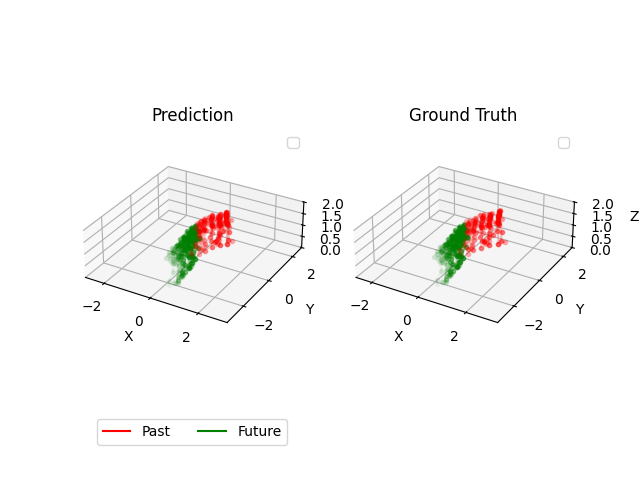

In [11]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from utils.plotter import plot_frame_sequence
%matplotlib widget


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load("../models/MoGen1.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

item = np.random.randint(0, 64)

criterion = MotionLoss(parent_indices)

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
ax1.set_title("Prediction")
ax2.set_title("Ground Truth")

# Create custom legend handles
legend_elements = [
    Line2D([0], [0], color='red', linestyle='-', markersize=8, label='Past'),
    Line2D([0], [0], color='green', linestyle='-', markersize=8, label='Future')
]

# Add custom legend to the figure
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.3, 0.1), ncol=2)

pred_positions = None
true_positions = None

for pm, rv, jv, rdq, jdq in dataloader:
    jv_flat = jv.view(jv.shape[0], jv.shape[1], -1)
    jdq_flat = jdq.view(jdq.shape[0], jdq.shape[1], -1)

    v = torch.cat((rv, jv_flat), dim=-1)  
    dq = torch.cat((rdq, jdq_flat), dim=-1)
    
    v = v.view(v.shape[0], v.shape[1], v.shape[-1]//3, -1)
    dq = dq.view(dq.shape[0], dq.shape[1], dq.shape[-1]//8, -1)

    pm_in = pm[:, :model.in_frames_len].to(device)
    pm_tar = pm[:, model.in_frames_len:].to(device)
    v_in = v[:, :model.in_frames_len].to(device)
    v_tar = v[:, model.in_frames_len:].to(device)
    dq_in = dq[:, :model.in_frames_len].to(device)
    dq_tar = dq[:, model.in_frames_len:].to(device)
    
    pm_out, v_out, dq_out, unnorm_dq = model(pm_in, v_in, dq_in)

    loss = criterion(pm_out, pm_tar, v_out, v_tar, dq_out, dq_tar, unnorm_dq)
    
    dq_out = torch.cat((dq_in, dq_out), dim=1)
    
    mats = dq2mat(dq_out)
  
    mats_transformed = mats.clone()
    mats_transformed[:, :, 1:, :, :] = torch.matmul(mats[:, :, 0, :, :].unsqueeze(2), mats[:, :, 1:, :, :])

    pred_positions = mats_transformed[..., :3, 3].detach().cpu().numpy()



    plot_frame_sequence(ax1, pred_positions[item].copy(), parent_indices, 6)

    dq_tar = torch.cat((dq_in, dq_tar), dim=1)

    mats = dq2mat(dq_tar)
  
    mats_transformed = mats.clone()
    mats_transformed[:, :, 1:, :, :] = torch.matmul(mats[:, :, 0, :, :].unsqueeze(2), mats[:, :, 1:, :, :])

    true_positions = mats_transformed[..., :3, 3].detach().cpu().numpy()

    plot_frame_sequence(ax2, true_positions[item].copy(), parent_indices, 6)
    break

In [20]:
from pythreejs import *
import numpy as np
from IPython.display import display, clear_output
import time

#  For choosing a random item from the batch
item = np.random.randint(0, 64)

# For generating checkers pattern
def gen_checkers(width, height, n_checkers_x, n_checkers_y):
    array = np.ones((width, height, 3), dtype='float32')

    # width in texels of each checker
    checker_w = width / n_checkers_x
    checker_h = height / n_checkers_y


    for y in range(height):
        for x in range(width):
            color_key = int(x / checker_w) + int(y / checker_h)
            if color_key % 2 == 0:
                array[x, y, :] = [ 0, 0, 0 ]
            else:
                array[x, y, :] = [ 1, 1, 1 ]
    # We need to flip x/y since threejs/webgl insists on column-major data for DataTexture
    return np.swapaxes(array, 0, 1)



pred = pred_positions[item][:, :, [0, 2, 1]]
true = true_positions[item][:, :, [0, 2, 1]]

frames = pred.shape[0]
print(frames)
# Create the scene
scene = Scene()

# Create a camera
camera = PerspectiveCamera(position=[4, 4, 3], lookAt=[0, 0, 0])

# Create a renderer
renderer = Renderer(camera=camera, scene=scene, controls=[OrbitControls(controlling=camera)], width=800, height=600)

# Create a ground plane
data_tex = DataTexture(
    data=gen_checkers(8, 8, 8, 8),
    format="RGBFormat",
    type="FloatType",
)
plane_geometry = PlaneGeometry(width=10, height=10)
plane_material = MeshBasicMaterial(map=data_tex, color="green", side='DoubleSide')
plane = Mesh(geometry=plane_geometry, material=plane_material)
plane.rotateX(np.deg2rad(90))
scene.add(plane)

# Material for the line segments
m1 = LineMaterial(linewidth=3, color='cyan')
m2 = LineMaterial(linewidth=3, color='red')

# Initialize positions with zeros
pos = [[(0, 0, 0), (0, 0, 0)] for _ in range(len(parent_indices))]

# Create the geometry and line objects
g1 = LineSegmentsGeometry(positions=pos)
g2 = LineSegmentsGeometry(positions=pos)
pred_lines = LineSegments2(g1, m1)
true_lines = LineSegments2(g2, m2)
scene.add(pred_lines)
scene.add(true_lines
          
          )
def update_positions(frame):
    pred_pos = []
    true_pos = []
    for i, parent in enumerate(parent_indices):
        if parent != -1:
            pred_pos.append([pred[frame][parent], pred[frame][i]])
            true_pos.append([true[frame][parent], true[frame][i]])

    g1.positions = pred_pos
    g2.positions = true_pos
    g1.positionsNeedUpdate = True
    g2.positionsNeedUpdate = True

# Initialize with the first frame
update_positions(0)

display(renderer)

def animate(frame):
    update_positions(frame)
    renderer.render(scene, camera)

for frame in range(frames):
    animate(frame % frames)
    time.sleep(10/30.0)

12


Renderer(camera=PerspectiveCamera(position=(4.0, 4.0, 3.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.…